# Explore Magnetron2 Output, Lognormal Priors


Let's take a look at what `magnetron2` actually returns.

This notebook does the analysis for the code where the priors on the component amplitude and rise time is a log-normal distribution rather than an exponential distribution.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats

#datadir = "/home/jetset3/Desktop/Astrovaria/Example_data/" # directory with test data
#res_dir = "/home/jetset3/Desktop/Astrovaria/magnetron2/code/" # directory with results
datadir = "../data/"
res_dir = "../code/"

Let's make a function for the Fast-Rise, Exponential Decay (FRED) model that magnetron2 uses for the individual components. We'll need that a little later.

In [2]:
def skewnorm(time, theta):
    """ The model method contains the actual function definition.
    Returns a numpy-array of size len(self.times)
    Parameters:
    event_time = start time of word relative to start time of time series
    scale = horizontal scale parameter to stretch/compress word
    skew = skewness parameter: how much faster is the rise than the decay?
    """
    t0 = theta[0]
    amp = theta[1]
    scale = theta[2]
    skew = theta[3]
    
    y = scipy.stats.skewnorm().pdf(time, skew, loc=t0, scale=scale)
    #t = (time - t0) / scale
    #y = np.zeros_like(t)
    #y[t <= 0] = np.exp(t[t <= 0])
    #y[t > 0] = np.exp(-t[t > 0] / skew)

    #y = np.array(y)*amp

    return y


### Loading the data

First, let's load the FRB data:

In [3]:
data = np.loadtxt(datadir + "FRB_test.txt")

Note: looks like Teresa's been running this only starting 50 samples in, so let's leave out the first 50 rows.

In [4]:
time = data[50:,0]
flux = data[50:,1]
flux_err = data[50:,2]
#time = data[:,0]
#flux = data[:,1]
#flux_err = data[:,2]

### Loading the Results

Let's see what the posterior looks like:

In [5]:
sample = np.loadtxt(res_dir + "posterior_sample.txt", skiprows=2)

nsamples = len(sample)
print("There are %i samples in the posterior"%nsamples)

There are 227 samples in the posterior


First, let's get out some of the global parameters: the background, and the hyperparameters for the prior distributions on the component amplitude, rise time, peak time and skewness parameter.

In [6]:
# background parameter
bkg = sample[:,0]

# dimensionality of a single component
burst_dims =  sample[:,1]
burst_dims = list(set(burst_dims))[0]

# total number of model components permissible in the model
compmax = sample[:,2]
compmax = list(set(compmax))[0]

# hyper-parameter (mean) of the Gaussian distribution used
# as prior for the spike amplitudes
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_amplitude = sample[:,3]
hyper_sigma_amplitude = sample[:,4]


# hyper-parameter (mean) for the exponential distribution used
# as prior for the spike rise time
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_risetime = sample[:,5]
hyper_sigma_risetime = sample[:,6]

# hyper-parameters for the lower and upper limits of the uniform
# distribution osed as a prior for the skew
hyper_lowerlimit_skew = sample[:,7]
hyper_upperlimit_skew = sample[:,8]

## distribution over number of model components
nbursts = sample[:, 9]
#print(nbursts)

# individual burst parameters for all 100 components
npos = sample[:,10:110] # peak position for all burst components
amp = sample[:,110:210] # amplitude for all burst components
scale = sample[:,210:310] # rise time for all burst components
skew = sample[:, 310:410] # skewness parameter for all burst components

# put all of the parameters together
pars_all = np.array([npos, amp, scale, skew]).T

# all of the mean models
ymodel_all = sample[:,-len(time):] # model flux

Text(0.5, 1.0, 'skewness parameter upper limit')

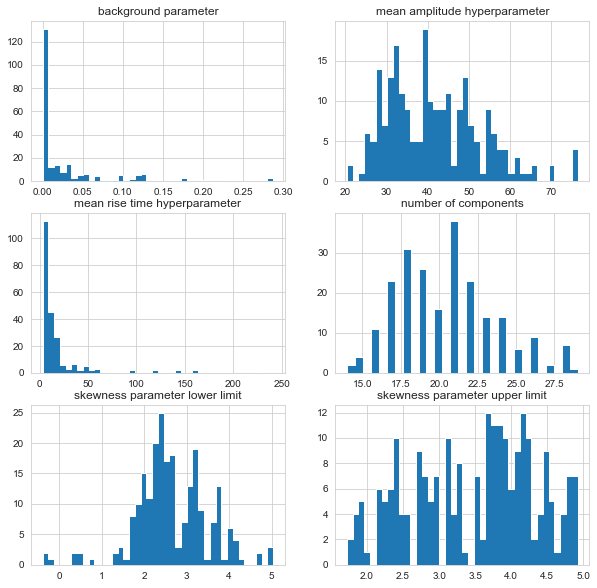

In [7]:
nbins = 40

fig, axes = plt.subplots(3,2, figsize=(10,10))
axes = np.hstack(axes)
axes[0].hist(bkg, bins=nbins, histtype="stepfilled")
axes[0].set_title("background parameter")

axes[1].hist(hyper_mean_amplitude, bins=nbins, histtype="stepfilled")
axes[1].set_title("mean amplitude hyperparameter")

axes[2].hist(hyper_mean_risetime, bins=nbins, histtype="stepfilled")
axes[2].set_title("mean rise time hyperparameter")

axes[3].hist(nbursts, bins=int(np.max(nbursts)), histtype="stepfilled")
axes[3].set_title("number of components")

axes[4].hist(hyper_lowerlimit_skew , bins=nbins, histtype="stepfilled");
axes[4].set_title("skewness parameter lower limit")

axes[5].hist(hyper_upperlimit_skew , bins=nbins, histtype="stepfilled");
axes[5].set_title("skewness parameter upper limit")



We can also plot what model fluxes drawn from the posterior look like. This can give us a first good indication of whether the model does a good job of actually fitting the data:

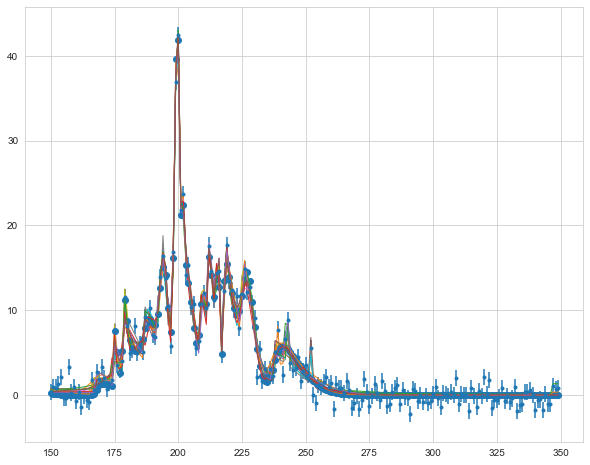

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))


#ax.plot(time, ytrue)
#ax.errorbar(time, yobs, yerr=yerr, fmt="o", markersize=5)
ax.errorbar(time, flux, yerr=flux_err, fmt="o", markersize=3)
for i in range(15):
    ax.plot(time, ymodel_all[i,:], lw=1)

The posterior is sampled from models with *lots* of components, of the order of 50 or so (see the plot above with the posterior distribution for the number of components). Why is that? Is that actually a good model for the data? There's a number of reasons why this could be the case:
* There actually are a lot of peaks in the data, we just don't see them well by eye (e.g. because of the noise)
* The FRED model for the components is a bad match to the actual shape of the bursts, so that it has to use multiple FRED components to get a good fit to one peak in the data
* The amplitude prior (unreasonably?) prioritizes small components in the  noise:

Let's look only at the noise part, so we'll leave out the first 100 data points:

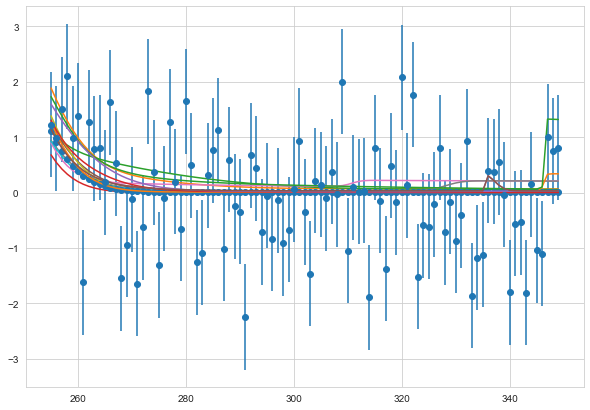

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))


#ax.plot(time, ytrue)
#ax.errorbar(time, yobs, yerr=yerr, fmt="o", markersize=5)
ax.errorbar(time[105:], flux[105:], yerr=flux_err[105:], fmt="o")
for i in range(15):
    ax.plot(time[105:], ymodel_all[i,105:])

Okay, so there's definitely lots of peaks in the noise. 

Three possible reasons come to mind:
* the uncertainties are underestimated. If this is true, then random wiggles in the data will be interpreted as real features and the model will put components there. If this is the case, I would expect that the *same* random wiggles will be interpreted as real features, so that many posterior samples will have components in the same position in time. 
* The prior (unreasonably?) prioritizes components with small amplitudes. By default, there's an exponential prior for the amplitude, which puts significant prior mass at small amplitudes. This means that a priori, the model *expects* there to be lots of peaks with small amplitudes, so it will place them. It'll randomly place them all over if there's little information in the data (for example because the noise is reasonably big).
* There is real, unrecognized structure in the data. It's also possible that there's real structure in what's currently considered noise, either because the FRB is actually longer, but most peaks are mostly hidden below the noise, or because there's structure imposed by the measurement process. 

Looking at the data, it's unclear which (if any) of these explanations might be true. 

Let's also look at a couple of individual peaks, and see how many components the model requires in order to represent individual peaks. For that, we need the parameters for the individual peaks, and we'll also need to make a model that can plot individual peaks.

### Plotting components for a single posterior sample

For a single posterior sample, let's plot the individual components that make up the overall model for the burst light curve.

We'll just pick the first set of parameters in the posterior sample:

In [10]:
idx = 0 # index for the first posterior sample

n = nbursts[idx] # number of components in the burst
print("The number of components in this model is " + str(n))

pars = pars_all[:, idx, :] # get out all of the parameters for that model
pars = pars[:int(n),:] # I only need the parameters that are non-zero and correspond to real components

The number of components in this model is 20.0


What does this model look like compared to the data?

(150.0, 349.0)

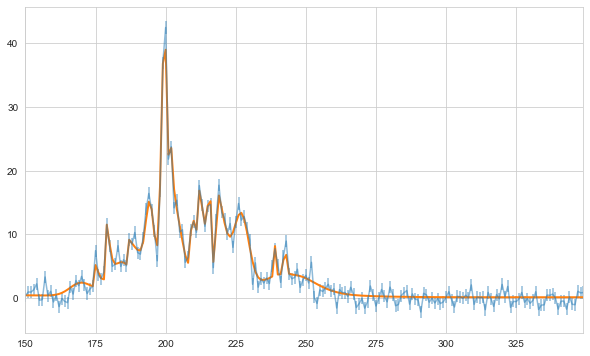

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

ymodel = ymodel_all[idx,:]

ax.plot(time, ymodel, lw=2)
ax.set_xlim(time[0], time[-1])

Okay, so just from looking at this, there are maybe 16 bigger peaks, and only two components in the noise, so where are all the other components?

Let's plot all of the components:

In [12]:
def skewnorm(time, theta):
    """ The model method contains the actual function definition.
    Returns a numpy-array of size len(self.times)
    Parameters:
    event_time = start time of word relative to start time of time series
    scale = horizontal scale parameter to stretch/compress word
    skew = skewness parameter: how much faster is the rise than the decay?
    """
    t0 = theta[0]
    amp = theta[1]
    scale = theta[2]
    skew = theta[3]
    
    y = scipy.stats.skewnorm(skew, loc=t0, scale=scale).pdf(time)
    #t = (time - t0) / scale
    #y = np.zeros_like(t)
    #y[t <= 0] = np.exp(t[t <= 0])
    #y[t > 0] = np.exp(-t[t > 0] / skew)

    #y = np.array(y)*amp

    return amp*y


(150.0, 349.0)

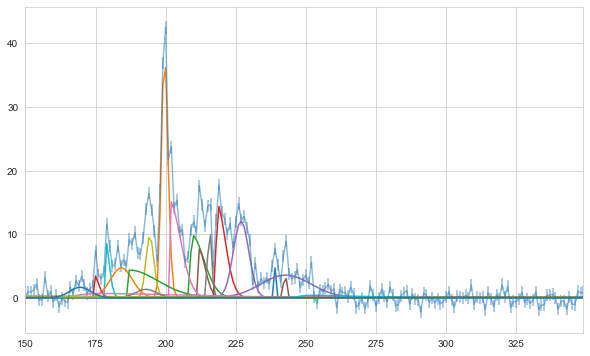

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# plot the data
ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

# make an empty array for the total model fluxes
ymodel = np.zeros_like(time)

# loop over the components
for p in pars:
    # compute single component flux
    ytest = skewnorm(time, p)
    
    # add component to the total flux
    ymodel += ytest
    
    # plot just the component
    ax.plot(time, ytest)

# set x-range
ax.set_xlim(time[0], time[-1])



Let's zoom in on the highest peak:

(195.0, 210.0)

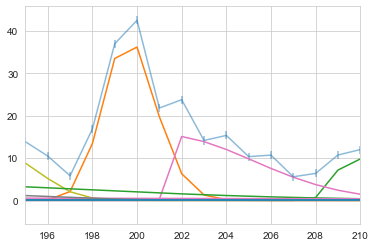

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(6,4))

# plot the data
ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

# make an empty array for the total model fluxes
ymodel = np.zeros_like(time)

# loop over the components
for p in pars:
    # compute single component flux
    ytest = skewnorm(time, p)
    
    # add component to the total flux
    ymodel += ytest
    
    # plot just the component
    ax.plot(time, ytest)

# set x-range
ax.set_xlim(195, 210)




So that highest peak is fit by at least six components in this burst, but it's worth noting here that it looks like there's lots of structure in this peak that looks much more significant than the uncertainties suggest. This may indicate that at higher time resolution, those wiggles might resolve into additional peaks, which might in turn suggest that perhaps the high number of peaks is not unjustified?

Let's make a function to plot the components:

In [15]:
def plot_components(time, flux, flux_err, pars, nbursts, 
                    ax=None, model_colour="orange", 
                    xlim=None, plot_data=True):
    """
    Plot a light curve and overplot examples from the 
    posterior from a magnetron2 sampling process.
    
    Plot individual components that make up the total 
    fluxes.
    
    Parameters
    ----------
    time : numpy.ndarray
        A 1D array with time stamps
        
    flux : numpy.ndarray
        A 1D array with observed fluxes
        
    flux_err : numpy.ndarray
        A 1D array with observed flux uncertainties
        
    pars : numpy.ndarray
        A 2D array of shape (nbursts, 4), where nbursts is the number of 
        (non-zero) burst components, and the four columns contain the 
        peak time (t0), amplitude (amp), rise time (scale) and skewness (skew), 
        in that order.

    nbursts : int 
        The number of non-zero burst components in this sample
        
    ax : matplotlib.Axes object, optional, default None
        Optionally, a matplotlib.Axes object can be passed in to 
        plot the components into an existing plot. If None, then 
        a new plot will be generated.
        
    model_colour : str, optional, default "orange"
        Set the colour for the components in the plot
        
    xlim : list of 2 elements, default None
        Set the limits ont he x-axis. If None, plot the 
        entire range of the `time` array
        
    plot_data : bool, default True
        If True, plot the data. If False, plot only the 
        posterior model components
        
    Returns
    -------
    ycomp : numpy.ndarray of shape (nbursts, len(time))
        An array with the model fluxes for all of the components
    
    ymodel : numpy.ndarray
        An array with the total model fluxes (all the components
        added up)
    
    ax : matplotlib.Axes object
        The matplotlib.Axes object, either generated or the one that 
        was passed in
    """
    # if ax is None, create a new plot:
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
        
    # plot the observed data
    ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

    # make an empty array for the total model fluxes
    ymodel = np.zeros_like(time)

    # make an empty list for the component fluxes
    ycomp = []
    
    # loop over the components
    for p in pars:
        # compute single component flux
        ytest = skewnorm(time, p)

        # add component to the total flux
        ymodel += ytest
        
        # save the component fluxes in a list
        ycomp.append(ytest)
        
        # plot just the component
        ax.plot(time, ytest, lw=1, color=model_colour, alpha=0.6)

    # if xlim is None, then set it to the limits of the 
    # time array
    if xlim is None:
        xlim = [time[0], time[-1]]
    
    # set x-range
    ax.set_xlim(*xlim)
    
    # turn the list of components into an array
    ycomp = np.array(ycomp)
    
    return ycomp, ymodel, ax


Let's give it a try:

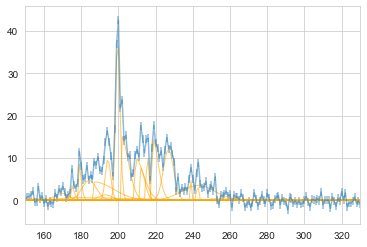

In [16]:
ycomp, ymodel, ax = plot_components(time, flux, flux_err, pars, nbursts, 
                    ax=None, model_colour="orange", xlim=[time[0],time[0]+180])

What I really want to do is (1) plot multiple posterior samples in different colours, and (2) focus on the interval of the most activity.

We can do that with the new function, where instead of `idx=0` as we've set above, we'll loop over multiple random indices:

Let's pick 10 random indices from the posterior:

In [17]:
idx_all = np.random.randint(0, nsamples, size=4)

Now we can loop over them, extract the parameters, and then plot the components in the posterior. It'll be *super* confusing, probably, but let's do it anyway:

The number of components in this model is 21.0
The number of components in this model is 14.0
The number of components in this model is 23.0
The number of components in this model is 21.0


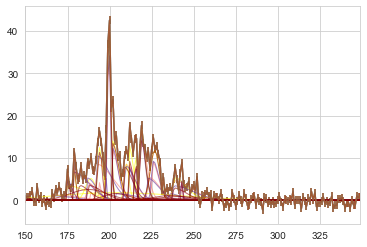

In [18]:
# First, let's set up the plot
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# define some colours for plotting using the HTML 
# colour names: https://htmlcolorcodes.com/color-names/

data_colour = "slateblue"
model_colours = ["salmon","yellow", "rebeccapurple", "darkred","aqua", "lawngreen", 
                  "darkorange", "fuchsia","teal", "springgreen", "chocolate", 
                 "mediumvioletred", "powderblue", "darkgreen", "saddlebrown"]

# let's now plot the actual data by hand, so that 
# it doesn't get plot *every* time we call the function
ax.errorbar(time, flux, yerr=flux_err, alpha=0.5, color=data_colour)

# loop over all indices
for i,idx in enumerate(idx_all):
    # get out the number of components in this model
    n = nbursts[idx]
    print("The number of components in this model is " + str(n))

    pars = pars_all[:, idx, :] # get out all of the parameters for that model
    pars = pars[:int(n),:] # I only need the parameters that are non-zero and correspond to real components
    
    # call the function we wrote. Set the `ax` keyword to the plot we made 
    # above so they all get plotted into the same plot. set `plot_data=False`, because 
    # we've already plotted the data above.
    ycomp, ymodel, ax = plot_components(time, flux, flux_err, pars, nbursts, 
                                        ax=ax, model_colour=model_colours[i], xlim=None,
                                        plot_data=False)

Chaos! Let's zoom in on the region with the most structure:

The number of components in this model is 21.0
The number of components in this model is 14.0
The number of components in this model is 23.0
The number of components in this model is 21.0


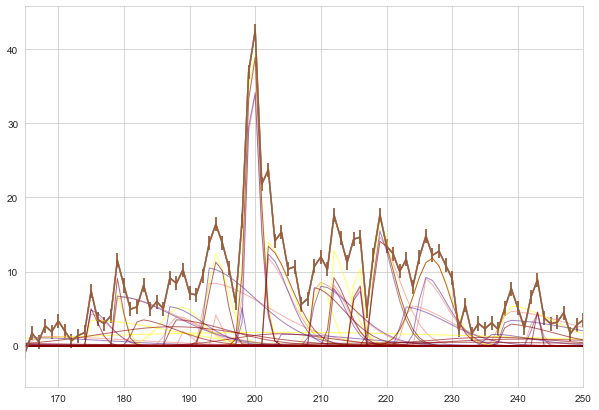

In [19]:
# First, let's set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10,7))

# xlimits:
xlim = [time[0]+15, time[0] + 100]


# define some colours for plotting using the HTML 
# colour names: https://htmlcolorcodes.com/color-names/

data_colour = "slateblue"
model_colours = ["salmon","yellow", "rebeccapurple", "darkred","aqua", "lawngreen", 
                  "darkorange", "fuchsia","teal", "springgreen", "chocolate", 
                 "mediumvioletred", "powderblue", "darkgreen", "saddlebrown"]

# let's now plot the actual data by hand, so that 
# it doesn't get plot *every* time we call the function
ax.errorbar(time, flux, yerr=flux_err, alpha=0.5, color=data_colour)

# loop over all indices
for i,idx in enumerate(idx_all):
    # get out the number of components in this model
    n = nbursts[idx]
    print("The number of components in this model is " + str(n))

    pars = pars_all[:, idx, :] # get out all of the parameters for that model
    pars = pars[:int(n),:] # I only need the parameters that are non-zero and correspond to real components
    
    # call the function we wrote. Set the `ax` keyword to the plot we made 
    # above so they all get plotted into the same plot. set `plot_data=False`, because 
    # we've already plotted the data above.
    ycomp, ymodel, ax = plot_components(time, flux, flux_err, pars, nbursts, 
                                        ax=ax, model_colour=model_colours[i], xlim=xlim,
                                        plot_data=False)

So it looks to me like there really is a lot of substructure in the data?